Наткнулся на две вещи:  

1) look_back = 1. Поставив большее значение, получаем что-то непонятное, а не сигнал. Есть одно "но", это работает только при втором пункте

2) batch_size = 1. Насколько  понял, это параметр, который говорит о том, что мы закидываем данные в tf пакетами по 50 значений. И вот изменяя эти два параметра в сумме, получаем плохой результат в конце.

Так что моё мнение, что в общем и целом, всё работало адекватно, просто потому, что мы поставили такие параметры и у нас модель ну очень хорошо обучалась

Epoch 1/5
65/65 - 2s - loss: 0.1451 - 2s/epoch - 27ms/step
Epoch 2/5
65/65 - 0s - loss: 0.0016 - 97ms/epoch - 1ms/step
Epoch 3/5
65/65 - 0s - loss: 0.0015 - 90ms/epoch - 1ms/step
Epoch 4/5
65/65 - 0s - loss: 0.0015 - 97ms/epoch - 1ms/step
Epoch 5/5
65/65 - 0s - loss: 0.0015 - 98ms/epoch - 2ms/step
49/49 [==============================] - 0s 977us/step
Train Score: 32.13 RMSE
Test Score: 30.42 RMSE


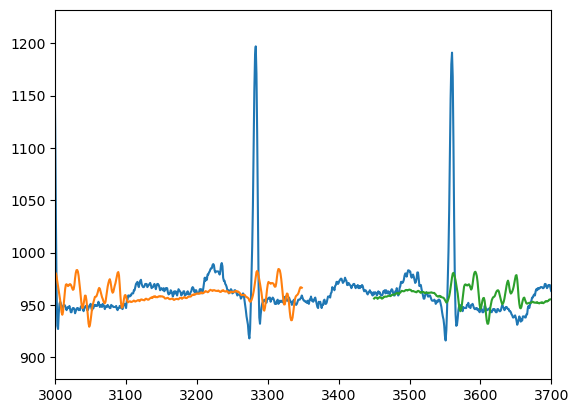

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility

tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('100.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
dataset = dataset[0:5000]
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 100    # Для физиологических сигналов look_back выбирается в пределах 3-5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=50, verbose=2) 

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim([3000,3700])
plt.show()